# Lab 1: Data exploration

In HW1, we did some basic data exploration and visualization. In this lab, we will continue digging through the data sets on the open data portal for more data wrangling and exploration practice. 


In addition to general data exploration, we also focus on geographical visualizations.

To start we'll need to install the following python libraries:
- geopandas
- folium

Install them with pip/conda:

<code>pip install geopandas
pip install folium
</code>

## Import libraries

In [2]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

As you've probably noticed while doing your homework, different neighborhoods/zipcodes have different distributions of 311 requests. We will attempt to visualize these differences.

Before we start, we'll need an the boundaries of the Chicago zipcodes, which we can get from: https://data.cityofchicago.org/Facilities-Geographic-Boundaries/Boundaries-ZIP-Codes/gdcf-axmw

First let's load our datasets and the zipcode geojson.

In [4]:
size = 20000
# Change these filepaths
df = pd.read_csv('MLforPublicPolicy/labs//data/311_Service_Requests_Graffiti_2019.csv',nrows=size)
geo_df = gpd.read_file('MLforPublicPolicy/labs/data/chi_boundaries.geojson')

In [6]:
# TODO: you might need to do preprocessing, convert columns to different types (date, string, integer, etc.)
df.drop('STATE', axis='columns',inplace=True)
df.drop('LEGACY_SR_NUMBER', axis='columns',inplace=True)
df.drop('PARENT_SR_NUMBER', axis='columns',inplace=True)
df.drop('CITY', axis='columns',inplace=True)
df.dropna(inplace=True)
geo_df.dropna(inplace=True)
df['zip'] = df['ZIP_CODE'].astype(int)
geo_df['zip'] = geo_df['zip'].astype(int)

## Choropleth Maps with geopandas
geopandas.read_file takes in a geojson file and creates a GeoDataFrame. You can read more about it from the [geopandas api](http://geopandas.org/data_structures.html). The GeoDataFrame can then be plotted right off the bat:

In [19]:
geo_df.head()

,objectid,shape_area,shape_len,zip,geometry
0,33,106052287.488,42720.0444058,60647,(POLYGON ((-87.67762151065281 41.9177578010629...
1,34,127476050.762,48103.7827213,60639,(POLYGON ((-87.72683253163021 41.9226462671259...
2,35,45069038.4783,27288.6096123,60707,(POLYGON ((-87.78500237831095 41.9091478547167...
3,36,70853834.3797,42527.9896789,60622,(POLYGON ((-87.6670686895295 41.88885188496992...
4,37,99039621.2518,47970.1401531,60651,(POLYGON ((-87.70655631674127 41.8955534069940...


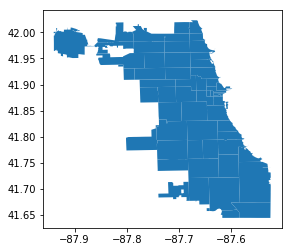

In [20]:
geo_df.plot()

This is not too interesting so let's try to make the plot tell us something about each of the zipcodes. We can do this by setting the column parameter which will then shade the zipcode block according to that column. You can supply a [matplotlib colormap](https://matplotlib.org/examples/color/colormaps_reference.html) string for the cmap parameter for different types of color gradients.

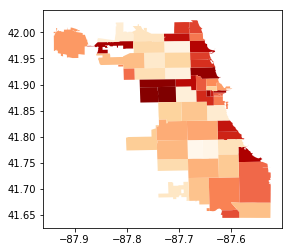

In [21]:
geo_df.plot(column='shape_area', cmap='OrRd')

Now, let's augment this geoDataFrame with a new column for the number of 311 requests of rodent complaints to see something a bit more interesting. To do this we'll create a dataframe for the number of 311 requests that each zipcode received in aggregate, and merge this to geo_df

In [9]:
# Get the counts
zip_counts = df.groupby('zip').count()
# Make a smaller dataframe with two columns: "zip" and "count"
zipcounts = pd.DataFrame({'zip': zip_counts.index, 'count': zip_counts['STATUS']})
zipcounts.head()

,count,zip
zip,,
60601,78,60601
60602,20,60602
60603,19,60603
60604,9,60604
60605,66,60605


In [10]:
# Join them onto geo_df
joined = geo_df.join(zipcounts, on='zip', how='left', lsuffix='l', rsuffix='r').dropna()    
# There is a cleaner way to do this, but I'll let you figure that out.

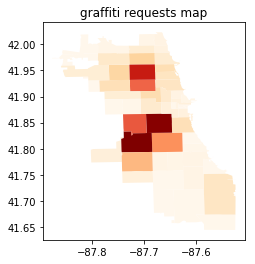

In [11]:
# Plot the map color coded by number of rodent 311 requests
joined.plot(column='count', cmap='OrRd')
plt.title('graffiti requests map')
plt.show()

## Heatmaps with folium

While these visualizations are useful in summarizing where we might expect more rodent/vacancy/etc requests to come from, they're a bit coarse because zipcode blocks can be pretty big. To get a finer grained view of where these requests happen, we'll learn how to plot a heatmap of these 311 requests using folium.

Recall that our 311 data contains the latitude and longitude of these values.

In [12]:
xy = df[['LATITUDE', 'LONGITUDE']]

In [13]:
import folium
from folium.plugins import HeatMap

/home/jingwen/.local/lib/python2.7/site-packages/folium/__init__.py:59: UserWarning: This version of folium is the last to support Python 2. Transition to Python 3 to be able to receive updates and fixes. Check out https://python3statement.org/ for more info.
  UserWarning


In [14]:
print(xy.mean())

LATITUDE     41.874676
LONGITUDE   -87.689482
dtype: float64


In [15]:
hmap = folium.Map(location=[41.87, -87.69], zoom_start=10)
hm_rod = HeatMap(list(zip(xy['LATITUDE'].values, xy['LONGITUDE'].values)), radius=13, blur=20)
hmap.add_child(hm_rod)

Play around with the zoom_start, radius and blur parameters to get a better sense of how they affect the resulting visualizations.

## Data Exploration Tips

Here are some things you want to do during data exploration:

1. Distributions of different variables
2. Correlations between variables - you can do a correlation matrix and turn it into a heatmap
3. Changes and trends over time - how does the data and the entities in the data change over time
4. Missing values - are there lots of missing values? is there any pattern there?
5. looking at outliers - this can be done using clustering (that we will cover later) but also using other methods by plotting distributions.
6. cross-tabs, describing how the different types of entities are different.

It's good to have code that does each of the things above. The exercises below are a start in helping you create that for yourself.


## Exercises:
Now that we've seen how to create some simple geographical visualizations you should aggregate the 311 requests by zipcode and visualize request frequency, average request completion time by location, and any other things you find interesting. Some specific questions that might be good to explore:


### Do certain neighborhoods get certain graffiti requests completed faster than others?




In [47]:
start_time = pd.to_datetime(df['CREATED_DATE'])
end_time = pd.to_datetime(df['CLOSED_DATE'])
df['duration'] = (pd.to_datetime(df['CLOSED_DATE']) - pd.to_datetime(df['CREATED_DATE'])).astype('timedelta64[h]')
df2 = pd.DataFrame({'zip': df['zip'], 'duration': df['duration']})
dur_avg = df.groupby('zip')['duration'].mean()
dur_avg.sort_values()

zip
60628     9.529412
60661    13.312500
60620    13.666667
60636    14.627907
60619    16.205128
60646    21.451613
60601    21.461538
60621    21.470588
60624    21.750000
60606    21.878049
60615    21.913043
60653    23.222222
60631    24.222222
60607    25.825000
60641    25.852941
60609    26.151675
60644    26.562500
60605    26.984848
60602    27.000000
60647    27.512431
60622    27.669565
60652    27.708861
60707    28.583333
60656    28.916667
60637    29.648649
60632    29.840453
60651    29.941176
60630    30.048951
60617    30.680723
60623    30.897878
60638    31.095238
60608    31.108638
60639    31.504808
60649    32.111111
60612    33.142857
60659    33.324074
60629    33.585746
60645    33.655172
60657    34.758621
60603    34.789474
60610    35.145833
60616    37.048309
60654    37.871429
60618    38.109544
60643    38.538462
60604    40.888889
60613    41.199095
60626    42.102041
60642    42.325758
60625    43.827703
60633    44.266667
60614    44.312139
60640   

### Is there any seasonality to the requests? what about seasonal variations in completion times?

In [63]:
#code
start_season = start_time.apply(lambda dt: (dt.month%12 + 3)//3)
start_season.value_counts()

1    8015
2    1590
Name: CREATED_DATE, dtype: int64

In [64]:
end_season = end_time.apply(lambda dt: (dt.month%12 + 3)//3)
end_season.value_counts()

1    7902
2    1703
Name: CLOSED_DATE, dtype: int64

### Are there any outliers in terms of completion times?

In [87]:
# code
outliers = df[ np.abs((df['duration'] - df['duration'].mean())/df['duration'].std()) > 3 ]
1.*len(outliers)/len(df)
(outliers['duration']/24.0)

215     36.166667
1542     9.041667
2133    63.833333
2494    74.166667
2635    88.583333
3506    16.958333
4423    14.916667
4434    14.875000
4438    14.833333
4440    14.958333
4455    14.916667
4496    14.708333
4509    14.708333
4564    13.958333
4589    13.875000
4630    13.833333
4633    13.958333
4701    13.666667
4707    13.333333
4708    13.333333
4741    13.041667
4783    13.083333
4848    12.916667
4899    12.625000
6708     7.291667
8612     9.000000
Name: duration, dtype: float64

### Which neighborhoods are the most similar in terms of graffiti service requests being reported?

In [131]:
# code
quants = [zipcounts['count'].quantile(.1*i) for i in range(0,11)]
quants
l = [(quants[i] <= zipcounts['count']) & (zipcounts['count'] < quants[i+1]) for i in range(10)]
for i in range(10):
    print(zipcounts[l[i]])

       count    zip
zip                
60604      9  60604
60631      9  60631
60649      9  60649
60653      9  60653
       count    zip
zip                
60620     12  60620
60633     15  60633
60643     13  60643
60644     16  60644
60656     12  60656
60661     16  60661
60707     12  60707
       count    zip
zip                
60602     20  60602
60603     19  60603
60615     23  60615
60624     24  60624
60628     17  60628
60645     29  60645
       count    zip
zip                
60611     35  60611
60619     39  60619
60621     34  60621
60637     37  60637
60646     31  60646
       count    zip
zip                
60605     66  60605
60606     41  60606
60610     48  60610
60626     49  60626
60636     43  60636
60660     58  60660
       count    zip
zip                
60601     78  60601
60607     80  60607
60634    100  60634
60638     84  60638
60652     79  60652
60654     70  60654
       count    zip
zip                
60612    133  60612
60640    118  60640


### References
http://pandas.pydata.org/pandas-docs/stable/timeseries.html

http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.groupby.html

http://geopandas.org/mapping.html

http://geopandas.org/mergingdata.html

http://python-visualization.github.io/folium/docs-v0.5.0/index.html

### Examples
http://blog.yhat.com/posts/interactive-geospatial-analysis.html

https://alcidanalytics.com/p/geographic-heatmap-in-python